<h1>Homebrew neural networks project review</h1>

I wanted to understand how neural networks work so I made a basic neural network using python and numpy. The results are in this repo and this is a jupyter notebook which I'm using to make a report on how the project went. A neural network is a series of artifical neurons arranged in layers with the layers feeding into each other. A simple neural network with 3 input neurons, a single hidden layer with 4 neurons and a output layer of 3 neurons is shown below:-

<img src="/example_simple_neural_network.png" width=50% align="middle">

A general pattern for a simple deep network is shown below:-

<img src="/neural_network_example_image.png" width=50% aligh="middle">

The input data is encoded in the input vector so the number of input neurons is fixed to the length of your input vector and the number of output neurons is the number of potential final states, e.g. if we wanted to classify pictures of numbers there would be 10 output neurons, one to give a confidence for each number 0-9. The hidden neurons are there to improve the performance of the network and getting the right number of hidden neurons and hidden layers for your task is a bit of an art.

The individual neurons are mathematical functions that combine the outputs from the previous layer, a weight unique to that neuron and a bias to produce an output for the neuron which is passed to the next layer. These factors are combined in a variable refered to here as z, the transfer function which is described below.

$z = (\sum w_{i} * x_{i}) + b_{i}$

Here $w_{i}$ and $x_{i}$ are the weights and these inputs for the neuron respectively where i indicates the neuron in the layer. This transfer function is then subjected to some activation function which is chosen when you set up the network. In this example I've used the sigmoid function shown below

$\sigma = \frac{1}{1 + e^{-z}}$

This function is plotted in the python cell below:-

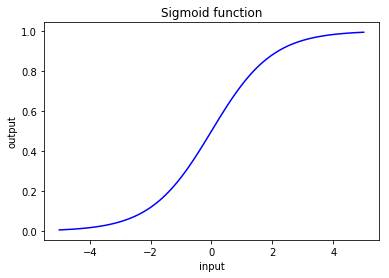

In [9]:
import matplotlib.pyplot as plt
import numpy as np


x = [float(i - 50)/10 for i in range(0, 101)]

y = [1/(1 + np.exp(-z)) for z in x]


plt.figure()
plt.plot(x, y, 'b-')
plt.title('Sigmoid function')
plt.xlabel('input')
plt.ylabel('output')
plt.show()


When combining the neurons into layers life is much easier if you use matrix multiplication to feed data through the network. So when we initialise the network we will save the weights and biases in a series of matrices, the weights are stored in a 3rd order tensor and the biases in a 2nd order tensor. Each neuron will have as many weights as there are neurons in the layer before and one bias. This means that to describe the weights for a layer we need a 2nd order tensor (like a 2d matrix if your not familiar with calling things tensors) and a 1st order tensor (like a vector) to describe the biases for a layer. You should have a play with the code in the block below to get a more intuative feel for how this works. It contains a class N_network which takes in a list of integers and creates the basic framework for a neural network. 

Have a play around with setting up a network and examining the shape of its weight and bias tensors, get a feel for how I put it together and for how I've encoded the weights and biases for the neurons in each layer. The variables A and Z will come into play when we start passing data through a neural network.

In [5]:
import numpy as np

class N_network:
    
    #initialise the matrix. This v.basic network can only work with simple
    #neurons applying a preset sigmoid function. No split layers/convolutions
    #/RNN etc.
    def __init__(self, layer_matrix):
        
        self.cost = []
        #layer matrix will contain a list of numbers with a number for the number
        #of nodes in each layer

        
        #work through the requested layers generating weights and biases for each layer
        weights = []
        biases = []
        for layer_no, layer in enumerate(layer_matrix[1:]):
            
            #generate weights for the layer with a maximum value of 0.05
            lay_weights = np.random.rand(layer_matrix[layer_no], layer) * 0.05
            
            #generate biases for the layer
            lay_bias = np.random.rand(layer_matrix[layer_no + 1])
            
            #save the layers weights and biases in matrices
            weights.append(np.matrix(lay_weights))
            biases.append(np.matrix(lay_bias))

        
        #set weights and biases as a properties of the network
        self.ws = weights
        self.bs = biases

        #save the shape of the network for easy access
        self.shape = layer_matrix
        
        #These variables are used to store data as it is passed through the network
        self.Z = []
        self.A = []
        
#Set the shape of an example network using a vector
example_network_shape = [3, 4, 3]

#Generate the example network
net = N_network(example_network_shape)


show_layer = 0

print("Shape of the weights tensor for layer %d"%show_layer)
print(np.shape(net.ws[show_layer]))

print("Shape of the biases tensor for layer %d"%show_layer)
print(np.shape(net.bs[show_layer]))

Shape of the weights for layer 0
(3, 4)
Shape of the biases for layer 0
(1, 4)


Now that we've initialised a neural network we should pass some data through. Trying to write code to process the result for each neuron separately using lists would be a huge pain in the arse (trust me I've tried) so instead we're going to use matrix multiplication, as enacted in the numpy module, to handle all that crap for us. We want to input a vector X and get back a vector Y which will be our output. 


To find the transfer function, z, for a given layer j we will multiply the result from the layer before by the weights matrix and add the bias matrix, simple enough and expressed in the following equation:

$z^{(j)} = A^{(j)}*W^{(j)} + B^{(j)}$

Here A is the output from the prevous layer after the activation function has been applied which, expressed mathematically using the sigmoid function we've chosen, means:

$A^{(j+1)} = \sigma(z^{(j)})$

We can then turn this into python script using the function shown below, which is a function of the neural network class.

In [ ]:
def feed_forward(self, X):

    a = X

    for layer, w in enumerate(self.ws):

        #use matrix maths to find the value of z for each node in the layer
        #then apply the bias
        z = a * w + self.bs[layer]

        self.Z.append(z)

        #apply the sigmoid function to the result of the matrix calculation
        #to find the neuron output for each node
        a = sig(z)

        self.A.append(a)


    return a

This is all well and good but we initialised the network with nothing but random numbers between 0 and 0.05, where does the learning come into this deep learning dodad. In order to 'teach' the neural network we have to use a method known as gradient descent. This is where the mathematics gets interesting however in writing the maths out I quickly got bored so you'd be better off going to find the derevation elsewhere since the following is copied into the notebook as quickly as possible and is probably full of typos and horrible writing. It should give you a general idea of the process of finding the gradients however. If we look at the result from our neural network and then compare it to the result we wanted to get we can find a 'cost', a measure of how well the network performed. Here we are going to define the cost, C as follows:

$C =  \frac{1}{2} (\hat{Y} - Y)^{2}$

Where $\hat{Y}$ is the output from the neural network and Y is the expected result. We square the result so that when we sum the costs from several results we always get a positive result. The factor of $\frac{1}{2}$ is there for reasons that will become apparant later.

In order to understand how gradient decent works we will have to think of this value C as our elevation in an n-dimentional plane. If n were 2 we would have a valley in a 3 dimensional world just like our own. The point of gradient decent is to decide which way we should go in the world to go downhill. This is easy to visualise when n is 2 as finding the way downhill in the hills. When we look at neural networks we are trying to find the way downhill in a valley where every one of our parameters, each weight and each bias is a dimension we might want to move in to find a way to the bottom of the hill. This means we can't just pick a direction and try it otherwise it would take till the end of time to find our way down the hill. So what we do is we measure the 'flatness' of the ground, which is to say we measure the rate of change of elevation below our feet. We differentiate the ground in order to detemine which way is downhill and then we go this way.

In order to do this we have to differentiate our cost by our weights and our biases, so we have to find:

$\frac{\partial C}{\partial W^{(j)}}$

and 

$\frac{\partial C}{\partial B^{(j)}}$

where j is the layer number.

Lets find the result for the weights first.

<h3> Finding the gradient for the weights </h3>

To calculate how we're going to change the weights we are going to calculate how the cost changes as we change the weights. This will tell us which direction to move in to go "downhill", we then multiply this value by a factor $\nu$, in the example code set to 0.05, and then add the result to the existing weights to improve the model slightly. We find this gradient using the equation below:

$\frac{\partial C}{\partial W^{(f)}} = \frac{1}{2}\frac{\partial \sum(Y - \hat{Y})^{2}}{\partial W^{(f)}}$


Now in order to make this into something we can calculate we are going to need to use the chain rule. The first substitution we will make is $u=Y - \hat{Y}$ meaning that, thanks to the chain rule, $\frac{\partial C}{\partial W^{(f)}}$ becomes:

$\frac{\partial C}{\partial W^{(f)}} = \sum(Y-\hat{Y})(-\frac{\partial \hat{Y}}{\partial W^{(f)}})$

Since Y is a constant it vanishes and the square eliminates the $\frac{1}{2}$ factor, this is why we included it earlier, to clean things up now. We took the summation out to tidy things up but remember its there but we removed it because it doesn't change the differentiation.

Now we need to find the result of $\frac{\partial \hat{Y}}{\partial W^{(f)}}$, the gradient of the output with respect to the weights in the final layer. In order to do this we need to use the chain rule again giving us:

$\frac{\partial \hat{Y}}{\partial W^{(f)}}=\frac{\partial \hat{Y}}{\partial z^{(f)}}\frac{\partial z^{(f)}}{\partial W^{(f)}}$

Now we can express $\hat{Y}$ in terms of $z^{(f)}$ as:

$\hat{Y} = \sigma(z^{(f)})$

This means we can find a value for $\frac{\partial \hat{Y}}{\partial z^{(f)}}$ by differentiating sigma by z, yielding:

$\sigma '(z) = \frac{e^{-z}}{(1 + e^{-z})^{2}}$

Now to find the value of $\frac{\partial z^{(f)}}{\partial W^{(f)}}$ we have to bear in mind that we defined z as:

$z = A^{(j)}*W^{(j)} + B^{(j)}$

so $\frac{\partial z^{(f)}}{\partial W^{(f)}}$ must be equal to $A^{f}$. We now have everything we need to find a numerical value for $\frac{\partial J}{\partial W^{(f)}}$:

$\frac{\partial C}{\partial W^{(f)}} = -(Y-\hat{Y})\sigma '(z^{(f)}) A^{(f)}$

Use the transpose of $A^{(f)}$ to get the matrix multiplications to work and put the sum back in to get:

$\frac{\partial C}{\partial W^{(f)}} = -A^{(f) T}\sigma '(z^{(f)})\sum(Y-\hat{Y})$

now define an error function $\delta^{(f)} = \sigma '(z^{(f)})\sum(Y-\hat{Y})$ and we have the change we must make to the weights in our backmost layer:-

$\frac{\partial C}{\partial W^{(f)}} = -A^{(f) T} \delta^{(f)}$

Now we want to find $\frac{\partial C}{\partial W^{(j)}}$ for the other layers. We do this by moving backwards through the network, hence back propagation. Calculating $\frac{\partial C}{\partial W^{f-1}}$ is computed in a similar way to $\frac{\partial C}{\partial W^{f}}$ except we now find:-

$\frac{\partial C}{\partial W^{(f-1)}} = -(Y-\hat{Y})(\sigma '(z^{(f)})(\frac{\partial z^{(f)}}{\partial W^{(f-1)}})$

If we subsistitue $\delta^{(f)}$ in here we have:

$\frac{\partial C}{\partial W^{(f-1)}} = \delta^{(f)}\frac{\partial z^{(f)}}{\partial A^{f-1}}\frac{\partial A^{(f)}}{\partial W^{(f-1)}}$

We make the substitution $\frac{\partial z^{(f)}}{\partial A^{f-1}} = W^{(f)T}$ leaving us with

$\frac{\partial C}{\partial W^{(f-1)}} = \delta^{(f)}(W^{(f)T})\frac{\partial A^{(f)}}{\partial W^{(f-1)}}$

Now we want to get rid of that $\frac{\partial A^{(f)}}{\partial W^{(f-1)}}$, we are going to do this by first expanding out using the chain rule again:-


$\frac{\partial A^{(f)}}{\partial W^{(f-1)}} = \frac{\partial A^{(f)}}{\partial z^{(f-1)}}\frac{\partial z^{(f-1)}}{\partial W^{(f-1)}}$

subing this back in we end up with 

$\frac{\partial C}{\partial W^{(f-1)}} = \delta^{f} W^{(f)T} \sigma '(z^{(f-1)}) \frac{\partial z^{(f-1)}}{\partial W^{(f-1)}}$

Then by subsitiuting $\frac{\partial z^{(f-1)}}{\partial W^{(f-1)}}$ for $A^{(f-1)}$ as we did in the first layer we're left with something we can compute

$\frac{\partial C}{\partial W^{(f-1)}} = \delta^{f} W^{(f)T} \sigma '(z^{(f-1)}) A^{(f-1)}$

Which we can simplify using $\delta^{f-1}$ to give the gradient for the layer as:-

$\frac{\partial C}{\partial W^{(f-1)}} = A^{(f-1)T} \delta^{f-1}$.

These values $\delta^{j}$ may seem arbitary however in the next section they will make life much easier.

<h3> Finding the gradient for the biases </h3>

When we calculate $\frac{\partial C}{\partial B^{(f)}}$ we find, due to the facts that there is only one bias per node and that B and z are liniarly dependent upon one another we can write the bias gradient for the final layer as:-

$\frac{\partial C}{\partial B^{(f)}} = \delta^{(f)}$

and when we perform back propogation this continues and we can simply state that:

$\frac{\partial C}{\partial B^{(j)}} = \delta^{(j)}$

making the calculations of bias gradients easy. This process is shown for both weights and biases in the code block below where the weight and bias gradients are calculated for a single epoch.

In [ ]:
def run_one_epoch(self, input_data, target_data, nu):

    [deltas, dJdWs, dJddi] = self.find_one_epoch(input_data, target_data)

    for layer_no, dJdW in enumerate(dJdWs):

        self.ws[layer_no] = self.ws[layer_no] - (nu * dJdW)

    for layer_no, dJdb in enumerate(dJddi):

        self.bs[layer_no] = self.bs[layer_no] - (nu * sum(dJdb))


    Y_hat = self.feed_forward(input_data)

    test_C = Y_hat - target_data

    cost = np.sum(abs(test_C))/len(test_C)

    return [cost, dJdWs]

The data we're going to be using to test our network is the MNIST handwritten digit dataset. I am using the set stored in the csv found here https://pjreddie.com/projects/mnist-in-csv/ but you can see an example of loading and displaying this data below:-

Running this specific window
[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]]
(28, 28)


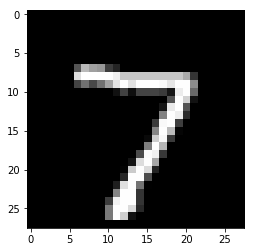

In [3]:
import numpy as np

import matplotlib.pyplot as plt

import numpy_neural_net_tools as nnn

def show_an_X(X, row_no):
    
    dat = np.array(X)[row_no]
    dat_rows = []
    
    for i, d in enumerate(dat):
    
        if i % 28 == 0:
            
            dat_rows.append([])
            
        dat_rows[-1].append(d)
    
    img = np.array(dat_rows)
    
    print(np.shape(dat_rows))
    
    plt.figure()
    plt.imshow(img, cmap='gray')

print("Running this specific window")

example_filename = './mnist_example.csv'
    
example_rows = nnn.load_csv(example_filename)


[X, Y] = nnn.process_rows4neural_net(example_rows)

print(Y[0])

show_an_X(X, 0)

An example code for making and running a neural network using my crappy code is shown below. I've tried to make it as simple as possible for myself but you may disagree. Also worth noting is that my code can only do a simple deep network and is therefore not remotly flexable. If you want to use this code and this jupyter notebbook for anything readd the code in the repository as a guide for how neural networks work but make sure you supplement that with a LOT of your own reading. In writing out the maths here I quickly lost patience and just started copying up not going back to find typos so give it a once over but if you see something diferent elsewhere go with that.

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

import numpy_neural_net_tools as nnn


test_filename = './MNIST_digit_dataset/mnist_test.csv'

train_filename = './MNIST_digit_dataset/mnist_train.csv'

print('loading csvs')

#train_rows = load_csv(train_filename)

train_rows = load_csv(train_filename)


[train_X, train_target] = process_rows4neural_net(train_rows)

print('Loaded train data')

test_rows = load_csv(test_filename)

[test_X, test_target] = process_rows4neural_net(test_rows)

print('test data')

#Test with the more complex data

eg_shape = [784, 300, 10]

#training rate
nu = 0.005

#initialise the network
net = N_network(eg_shape)

print('training')

cost = net.run_back_prop_batch(train_X, train_target, test_X, test_target, 20000, nu)

print("Final cost is:- %f"%float(cost))

#Lets find out how many it got wrong

result = net.feed_forward(test_X)

wrongs = 0
for i, y in enumerate(result):
    
    if np.argmax(result[i]) != np.argmax(test_target[i]):
        wrongs += 1
        
per = float(wrongs)/len(result) * 100
print("Got the wrong answer %d times, %d%% of the time"%(wrongs, per))

#plot the cost over the training
import matplotlib.pyplot as plt

plt.figure()
plt.plot(net.cost)
plt.title('Training results on MNIST dataset')
plt.xlabel('epoch')
plt.ylabel('cost')
plt.show()


<h2>Lessons learned</h2>

* Initial weights should be small, otherwise the network saturates and refuses to learn anything
* If your doing neural networks for god sake use matricies. In my first attempt I tried using lists and the indexing very quickly got very confusing
* DIY neural networks run crazy slow. Use tensorflow/keras/pytorch/whatever framework built by someone who's full time job is this shit. They handled the optimisation so you don't have to
* Biases are actually really powerful and quite easy to implement
* Data pre-processing is an arse, everything has to be between the limits of the activation function otherwise it saturates and refuses to learn anything

<h2>Final thoughts</h2>

I'm going to call this project a success and move on. There's other stuff I could do like implement different activation functions, add a momentum to the training, create a GUI to show the training process, try to create convolutional layers or try and make networks to do some different things but I've already spent way to long on this project (mostly due to procrastination naturally). If for some insane reason you want to expand my horrible code go ahead and clone the repo and play arround with it locally but since this I did this project for me and only posted it to github so it wouldn't feel like a massive waste of time so I don't really want to hear about what your up to. Also if you do do that, for the love of god why. Use a proper framework like tensorflow/keras/pytorch. Anyway, references:

1. https://en.wikipedia.org/wiki/Neural_Network
2. http://neuralnetworksanddeeplearning.com/
3. https://www.youtube.com/watch?v=bxe2T-V8XRs
4. https://www.tensorflow.org/
5. https://keras.io/
6. http://pytorch.org/